In [1]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('TestFileTemplate.csv')

In [4]:
print(train.shape)
print(test.shape)

(1000000, 7)
(50, 6)


In [5]:
print(train.head())
test.head()


       pickup_datetime  NumberOfPassengers  duration    pickup_x    pickup_y  \
0  2034-06-07 20:47:29                   1       434  135.428113  321.190773   
1  2034-04-14 08:00:21                   1       415  148.781291  322.565536   
2  2034-04-20 18:57:16                   2       398  124.000006  313.347763   
3  2034-04-28 22:40:52                   1       746  124.288413  316.495404   
4  2034-05-28 11:39:56                   1       102  177.344861  358.087844   

    dropoff_x   dropoff_y  
0  141.317712  321.357802  
1  157.145868  337.052655  
2  131.362606  300.613585  
3  143.284351  334.542116  
4  168.709489  363.038196  


,pickup_datetime,NumberOfPassengers,pickup_x,pickup_y,dropoff_x,dropoff_y
0,6/7/34 20:47,1,135.428113,321.190773,141.317712,321.357802
1,4/14/34 8:00,1,148.781291,322.565536,157.145868,337.052655
2,4/20/34 18:57,2,124.000006,313.347763,131.362606,300.613585
3,4/28/34 22:40,1,124.288413,316.495404,143.284350,334.542116
4,5/28/34 11:39,1,177.344861,358.087844,168.709489,363.038196


change the formatting of the date variables (`pickup_datetime` and `dropoff_datetime`)

In [6]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [7]:
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [8]:
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1     99525
 2    147047
 3    178354
 4    172556
 5    173839
 6    161219
 7     67460
 dtype: int64, Month
 1     2
 2     8
 3     7
 4    11
 5    13
 6     8
 7     1
 dtype: int64)

In [9]:
#No of days in a month
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 26)

In [10]:
#24 hours
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 19)

In [11]:
#No of days
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

(7, 7)

In [12]:
train = train.assign(log_duration = np.log(train.duration+1))

In [13]:
train.head()

,pickup_datetime,NumberOfPassengers,duration,pickup_x,pickup_y,dropoff_x,dropoff_y,Month,DayofMonth,Hour,dayofweek,log_duration
0,2034-06-07 20:47:29,1,434,135.428113,321.190773,141.317712,321.357802,6,7,20,2,6.075346
1,2034-04-14 08:00:21,1,415,148.781291,322.565536,157.145868,337.052655,4,14,8,4,6.030685
2,2034-04-20 18:57:16,2,398,124.000006,313.347763,131.362606,300.613585,4,20,18,3,5.988961
3,2034-04-28 22:40:52,1,746,124.288413,316.495404,143.284351,334.542116,4,28,22,4,6.616065
4,2034-05-28 11:39:56,1,102,177.344861,358.087844,168.709489,363.038196,5,28,11,6,4.634729


In [14]:
test.head()

,pickup_datetime,NumberOfPassengers,pickup_x,pickup_y,dropoff_x,dropoff_y,Month,DayofMonth,Hour,dayofweek
0,2034-06-07 20:47:00,1,135.428113,321.190773,141.317712,321.357802,6,7,20,2
1,2034-04-14 08:00:00,1,148.781291,322.565536,157.145868,337.052655,4,14,8,4
2,2034-04-20 18:57:00,2,124.000006,313.347763,131.362606,300.613585,4,20,18,3
3,2034-04-28 22:40:00,1,124.288413,316.495404,143.284350,334.542116,4,28,22,4
4,2034-05-28 11:39:00,1,177.344861,358.087844,168.709489,363.038196,5,28,11,6


# features :
1) Day of the week - weekday/weekend
2) Time of the day - 
3) Distance between point a and point b
4) Pickup location - congestion or non congestion
5) Locality - Clusters
6) Weather - Temperature - will be unknown for Gotham City

In [15]:
def rushhour(df):
  if df['Hour'] <= 6:
    return(1)
  elif df['Hour'] <= 12:
    return(2)
  elif df['Hour'] <=18:
    return(3)
  else:
    return(4)

In [16]:
# rush vs non-rush hour
train['rushhr']= train.apply(rushhour, axis=1)
test['rushhr']= test.apply(rushhour, axis=1)

In [17]:
#Weekday/Weekend
def weekdayend(df):
  if (df['dayofweek'] == 1) or (df['dayofweek'] == 2) or (df['dayofweek'] == 3) or (df['dayofweek'] == 7):
    return(0)
  else:
    return(1)

In [18]:
train['weekendweekday']= train.apply(weekdayend, axis=1)
test['weekendweekday']= test.apply(weekdayend, axis=1)

In [19]:
time_train = pd.DataFrame(index = range(len(train)))
time_test = pd.DataFrame(index = range(len(test)))

In [20]:
#calculate the route distance - haversine distance

In [21]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [22]:
def dummy_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return(a+b)

In [23]:
def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [24]:
List_dist = []
for df in (train,test):
    lat1, lng1, lat2, lng2 = (df['pickup_x'].values, df['pickup_y'].values, 
                              df['dropoff_x'].values,df['dropoff_y'].values)
    dist = pd.DataFrame(index=range(len(df)))
    dist = dist.assign(haversind_dist = haversine_array(lat1, lng1, lat2, lng2))
    dist = dist.assign(dist = dummy_distance(lat1, lng1, lat2, lng2))
    dist = dist.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))
    List_dist.append(dist)

Other_dist_train,Other_dist_test = List_dist

In [25]:
Other_dist_train

,haversind_dist,dist,bearing
0,655.040130,668.124130,-1.270497
1,1707.360189,2306.736966,-60.526185
2,1187.963955,1609.366342,51.788604
3,2511.100400,3239.548629,-40.290921
4,1104.510303,1510.072294,-150.621927
5,1752.672945,2411.856454,-48.013575
6,519.275460,681.597694,-160.517251
7,3713.962020,4762.913727,-111.348973
8,1486.863649,1503.694497,-179.420333
9,4799.164101,6681.580790,-56.805896


In [26]:
train['Distance'] = Other_dist_train['dist']
test['Distance'] = Other_dist_test['dist']

# K-Means clustering of coordinates

In [27]:
coord_pickup = np.vstack((train[['pickup_x', 'pickup_y']].values,                  
                          test[['pickup_x', 'pickup_y']].values))
coord_dropoff = np.vstack((train[['dropoff_x', 'dropoff_y']].values,                  
                           test[['dropoff_x', 'dropoff_y']].values))

In [28]:
coords = np.hstack((coord_pickup,coord_dropoff))# 4 dimensional data
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10000).fit(coords[sample_ind])
for df in (train,test):
    df.loc[:, 'pickup_dropoff_loc'] = kmeans.predict(df[['pickup_x', 'pickup_y',
                                                         'dropoff_x','dropoff_y']])

In [29]:
kmean10_train = train[['pickup_dropoff_loc']]
kmean10_test = test[['pickup_dropoff_loc']]

In [30]:
train.head()

,pickup_datetime,NumberOfPassengers,duration,pickup_x,pickup_y,dropoff_x,dropoff_y,Month,DayofMonth,Hour,dayofweek,log_duration,rushhr,weekendweekday,Distance,pickup_dropoff_loc
0,2034-06-07 20:47:29,1,434,135.428113,321.190773,141.317712,321.357802,6,7,20,2,6.075346,4,0,668.124130,1
1,2034-04-14 08:00:21,1,415,148.781291,322.565536,157.145868,337.052655,4,14,8,4,6.030685,2,1,2306.736966,6
2,2034-04-20 18:57:16,2,398,124.000006,313.347763,131.362606,300.613585,4,20,18,3,5.988961,3,0,1609.366342,1
3,2034-04-28 22:40:52,1,746,124.288413,316.495404,143.284351,334.542116,4,28,22,4,6.616065,4,1,3239.548629,1
4,2034-05-28 11:39:56,1,102,177.344861,358.087844,168.709489,363.038196,5,28,11,6,4.634729,2,1,1510.072294,0


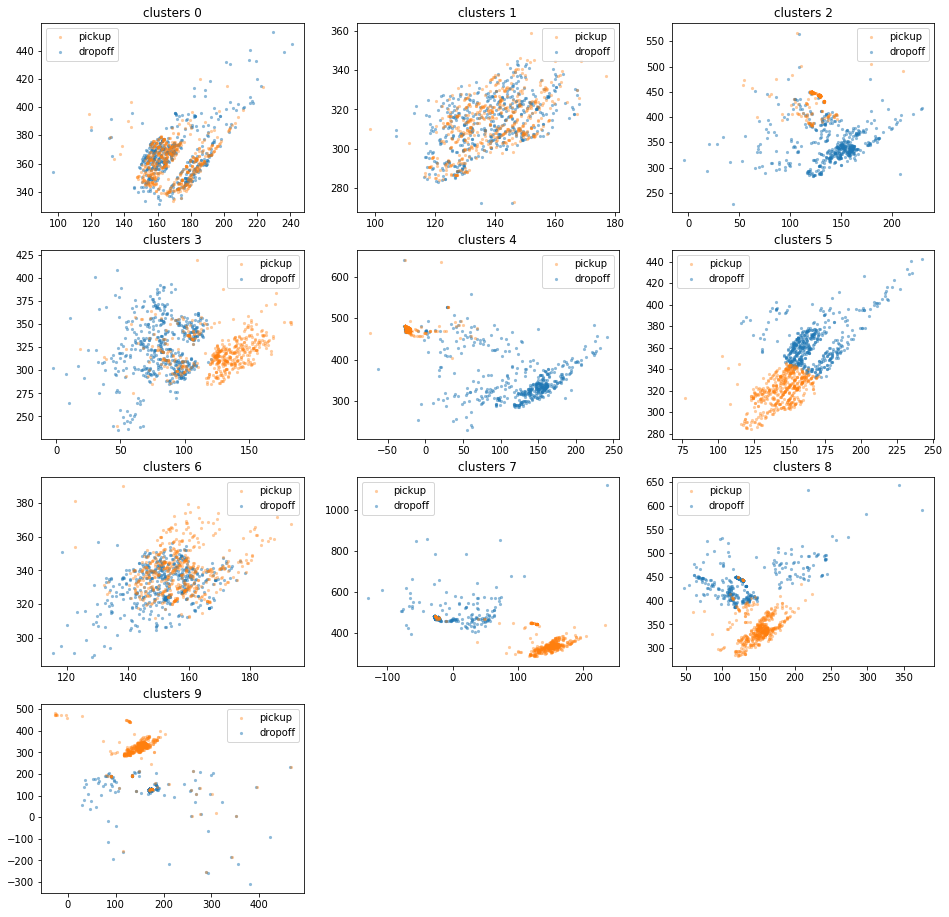

In [31]:
plt.figure(figsize=(16,16))
N = 500
for i in range(10):
    plt.subplot(4,3,i+1)
    tmp_data = train[train.pickup_dropoff_loc==i]
    drop = plt.scatter(tmp_data['dropoff_x'][:N], tmp_data['dropoff_y'][:N], s=10, lw=0, alpha=0.5,label='dropoff')
    pick = plt.scatter(tmp_data['pickup_x'][:N], tmp_data['pickup_y'][:N], s=10, lw=0, alpha=0.4,label='pickup')    
    plt.legend(handles = [pick,drop])
    plt.title('clusters %d'%i)
#plt.axes().set_aspect('equal')

#Check Outliers

Text(0, 0.5, 'frequency')

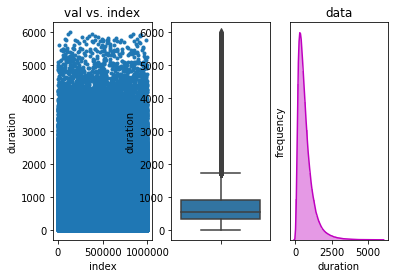

In [32]:
y = np.array(train.duration)
plt.subplot(131)
plt.plot(range(len(y)),y,'.');plt.ylabel('duration');plt.xlabel('index');plt.title('val vs. index')
plt.subplot(132)
sns.boxplot(y=train.duration)
plt.subplot(133)
sns.distplot(y,bins=50, color="m");plt.yticks([]);plt.xlabel('duration');plt.title('data');plt.ylabel('frequency')
#plt.hist(y,bins=50);

#Outliers - Trip Duration

In [33]:
y = np.array(train.duration)

In [34]:
outliers_trip_duration=np.array([False]*len(train))

In [35]:
outliers_trip_duration[y<30] = True

In [36]:
sum(outliers_trip_duration)

3811

In [37]:
train['outliers_trip_duration'] = outliers_trip_duration

In [38]:
train.shape

(1000000, 17)

In [39]:
#Drop trip_duration outliers
# Get names of indexes for which column outlier_trip_duration has value 'True'
indexNames = train[ train['outliers_trip_duration'] == True ].index
 
# Delete these row indexes from dataFrame
train.drop(indexNames , inplace=True)

#Outliers-Speed

In [40]:
kph = train.Distance/1000/train.duration*3600

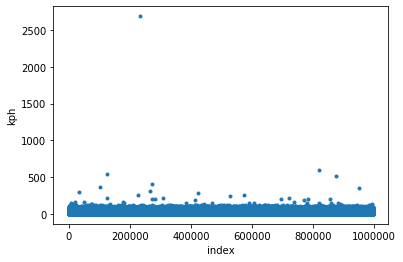

In [41]:
plt.plot(range(len(kph)),kph,'.');plt.ylabel('kph');plt.xlabel('index');plt.show()

In [42]:
outliers_speed=np.array([False]*len(train))

In [43]:
outliers_speed[kph>120] = True

In [44]:
sum(outliers_speed)

65

In [45]:
train['outliers_speed'] = outliers_speed

In [46]:
train.shape

(996189, 18)

In [47]:
#Drop speed outliers
# Get names of indexes for which column outlier_speed has value 'True'
indexNames = train[train['outliers_speed'] == True ].index
 
# Delete these row indexes from dataFrame
train.drop(indexNames , inplace=True)

#Modeling

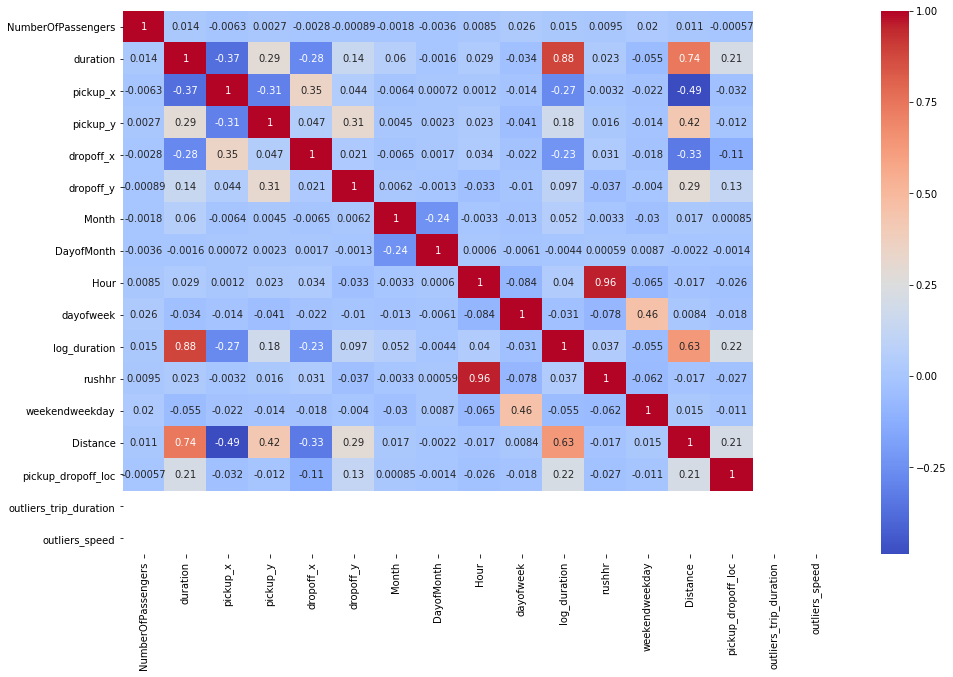

In [48]:
plt.figure(figsize=(16,10))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)

In [49]:
traindf = train[['Distance','dayofweek','Hour', 'pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y'  ]]

testdf = test[['Distance','dayofweek','Hour', 'pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y' ]]

In [58]:
X = traindf
z = train.log_duration.values
#z = train.duration.values

In [52]:
import xgboost as xgb

In [59]:
from sklearn.model_selection import train_test_split

#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=0)
Xcv,Xv,Zcv,Zv = train_test_split(Xval, Zval, test_size=0.5, random_state=1)
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xcv   , label=Zcv)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
rand_forest_regressor = RandomForestRegressor()
rand_forest_regressor.fit(Xtrain, Ztrain)

y_rand_forest_predict = rand_forest_regressor.predict(Xval)
random_forest_model_error = sqrt(mean_squared_error(np.expm1(Zval), np.expm1(y_rand_forest_predict)))

/Users/pranidhiprabhat/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [61]:
print(f' Random Forest Mean Squared Error - {random_forest_model_error}')

 Random Forest Mean Squared Error - 258.51681922770354


In [70]:
import lightgbm as lgb

/Users/pranidhiprabhat/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [71]:
lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=35, n_estimators=300)
lgb_model.fit(Xtrain, Ztrain)
y_LGB_predict = lgb_model.predict(Xval)
LGB_model_error = sqrt(mean_squared_error(np.expm1(Zval), np.expm1(y_LGB_predict)))
print(f'LGBM Mean Squared Error - {LGB_model_error}')

LGBM Mean Squared Error - 255.1416064712437


In [72]:
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:linear',
         'eta'      :0.05,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10,
         'nthread'  :3}  #number of cpu core to use

In [73]:
model = xgb.train(parms, data_tr, num_boost_round=1000, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=100)

print('score = %1.5f, n_boost_round =%d.'%(model.best_score,model.best_iteration))

[22:02:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5.54884	valid-rmse:5.55009
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[100]	train-rmse:0.362269	valid-rmse:0.365258
[200]	train-rmse:0.348688	valid-rmse:0.354767
[300]	train-rmse:0.340283	valid-rmse:0.349009
[400]	train-rmse:0.335068	valid-rmse:0.34569
[500]	train-rmse:0.332262	valid-rmse:0.344665
[600]	train-rmse:0.328245	valid-rmse:0.342243
[700]	train-rmse:0.324875	valid-rmse:0.340537
[800]	train-rmse:0.322624	valid-rmse:0.339784
[900]	train-rmse:0.319933	valid-rmse:0.338583
[999]	train-rmse:0.317175	valid-rmse:0.337421
score = 0.33742, n_boost_round =996.


In [63]:
data_test = xgb.DMatrix(Xval)
ztest = model.predict(data_test)

In [ ]:
ensembled_prediction = (0.5*np.expm1(ztest))+(0.5*np.expm1(y_LGB_predict))
ensembled_prediction_error = sqrt(mean_squared_error(np.expm1(Zval), ensembled_prediction))

print(f'Ensembled Mean Squared Error - {ensembled_prediction_error}')

In [ ]:
#Predicting final test values

In [ ]:
y_XGB_predict = model.predict(data_test)

In [ ]:
y_LGB_predict = np.expm1(lgb_model.predict(X_test_dataset))

In [ ]:
ensembled_prediction = (0.5*y_XGB_predict)+(0.5*y_LGB_predict)
submission.to_csv('ensembled_submission.csv', index=False)
submission.head(10)

In [128]:
cv_results = xgb.cv(
    parms,
    data_cv,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

[20:43:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:43:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language b

In [60]:
cv_results['test-mae-mean'].min()

0.2570456

In [64]:
ytest = np.exp(ztest-1)
print(ytest[:10])

[244.70651 210.94638 355.53302 140.67499 707.644   407.02823 122.32724
 365.5083  167.4633  150.64563]


In [ ]:
from sklearn.metrics import mean_absolute_error

In [66]:
# "Learn" the mean from the training data
mean_train = np.mean(z)
# Get predictions on the test set
baseline_predictions = np.ones(ztest.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(ytest, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 239.08


In [138]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

print(metrics.mean_squared_error(ytest, ztest))
print(np.sqrt(metrics.mean_squared_error(ytest,ztest)))

87485.72
295.77985


## Don't Run-Hyperparameter Tuning

In [45]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10)
    for min_child_weight in range(8,12)
]

In [46]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    parms['max_depth'] = max_depth
    parms['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        parms,
        data_cv,
        num_boost_round=1000,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=6, min_child_weight=8
[13:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/software/hadoop/python36/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	MAE 0.28999559999999996 for 202 rounds
CV with max_depth=6, min_child_weight=9
[13:50:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.2901306 for 226 rounds
CV with max_depth=6, min_child_weight=10
[13:51:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:51:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now d

In [50]:
# tuning eta 
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    parms['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(parms,
                                data_cv,
                                num_boost_round=1000,
                                seed=42,
                                nfold=5,
                                metrics=['mae'],
                                early_stopping_rounds=10
          )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 31.5 µs
CV with eta=0.3
[14:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/software/hadoop/python36/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	MAE 0.2888112 for 126 rounds

CV with eta=0.2
[14:04:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.2846876 for 237 rounds

CV with eta=0.1
[14:06:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:06:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:06:07] WARNIN

# Prediction on Test Data

In [129]:
test.head()

,pickup_datetime,NumberOfPassengers,pickup_x,pickup_y,dropoff_x,dropoff_y,Month,DayofMonth,Hour,dayofweek,rushhr,weekendweekday,Distance,pickup_dropoff_loc
0,2034-03-14 08:28:17,2,155.108652,322.284140,148.058424,332.814003,3,14,8,1,2,0,1845.786703,2
1,2034-04-20 09:04:41,1,146.628808,306.343423,154.284090,339.899155,4,20,9,3,2,0,3953.483139,1
2,2034-01-25 00:46:04,2,132.028079,319.183942,149.318583,384.810789,1,25,0,2,1,0,6653.385487,1
3,2034-02-01 22:20:46,2,175.776769,344.277029,159.039740,311.756787,2,1,22,2,4,0,5467.068525,2
4,2034-04-15 23:29:21,2,128.428489,295.153348,126.011933,309.548102,4,15,23,5,4,1,1261.947305,1


In [127]:
testdf.head()

,Distance,dayofweek,Hour,pickup_x,pickup_y,dropoff_x,dropoff_y
0,1845.786703,1,8,155.108652,322.284140,148.058424,332.814003
1,3953.483139,3,9,146.628808,306.343423,154.284090,339.899155
2,6653.385487,2,0,132.028079,319.183942,149.318583,384.810789
3,5467.068525,2,22,175.776769,344.277029,159.039740,311.756787
4,1261.947305,5,23,128.428489,295.153348,126.011933,309.548102


In [137]:
#Make predictions on test data frame
data_test = xgb.DMatrix(testdf)
ztest = model.predict(data_test)
ytest = np.exp(ztest-1)
print(ytest[:10])

[190.10838 412.94916 337.47318 230.22418 190.06679 724.1901   75.3582
  79.36563 152.58974 437.82657]


In [136]:
#Create a data frame for submission
final_result = pd.DataFrame({'duration': ytest})
final_result.head()

,duration
0,190.108383
1,412.949158
2,337.473175
3,230.224182
4,190.066788


In [133]:
#Create a csv out of the submission data frame
final_result.to_csv("G.csv", index=False)